# Predict Possible Defaulters for Loans

In [1]:
#import the useful libraries.
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter

#Importing Models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#Importing preprocessors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.model_selection import RandomizedSearchCV , GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,cross_val_score
from sklearn.metrics import confusion_matrix , classification_report, make_scorer
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import plot_roc_curve ,roc_curve, roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# to suppress the warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split 
from sklearn import linear_model
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE


# Business understanding


In finance, a loan is the lending of money by one or more individuals, organizations or other entities to other individuals, organizations etc. The recipient (i.e. the borrower) incurs a debt, and is usually liable to pay interest on that debt until it is repaid, and also to repay the principal amount borrowed.

A loan in time enables the borrower to meet financial goals. At the same time, the interest associated with the loan generates revenues for the lender.

However, there is always a risk associated with lending, especially in case of customers having insufficient or non-existent credit histories. If the borrower defaults a loan, then that loan becomes non-performing asset (or, NPA) for the lender. Any NPA hits the bottom-line of the lending organization.

Therefore, every lending organization strives to assess the risk associated with the loan. Primarily, they want to assess their clients' repayment abilities well in advance before deciding on approval and disbursement of loans. Objective of this project is to build a loan default risk classifier. The classifier will be supervised classifier who can be trained on historical data, and classify a new loan accordingly.

An organization wants to predict who possible defaulters are for the consumer loans product. They have data about historic customer behavior based on what they have observed. Hence when they acquire new customers they want to predict who is riskier and who is not.

Objective of this project is to build a classifier that, depending on the loan application, can predict whether an applicant will be able to repay the loan or not. This classifier will help bank to approve or reject a loan application efficiently.

# 1. Data Preperation


# 1. Data Understanding

In [87]:
df=pd.read_csv(r'E:\Great learning\Capstone\Datasets\Training Data.csv')
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


### Loading the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [83]:
df.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,"252,000.00","252,000.00","252,000.00","252,000.00","252,000.00","252,000.00"
mean,"4,997,116.67",49.95,10.08,6.33,12.00,0.12
std,"2,878,311.01",17.06,6.00,3.65,1.40,0.33
min,"10,310.00",21.00,0.00,0.00,10.00,0.00
25%,"2,503,015.00",35.00,5.00,3.00,11.00,0.00
50%,"5,000,694.50",50.00,10.00,6.00,12.00,0.00
75%,"7,477,502.00",65.00,15.00,9.00,13.00,0.00
max,"9,999,938.00",79.00,20.00,14.00,14.00,1.00


It can be observed that there are a total of 2,52,000 records

By looking at the datatypes of columns, we can say that all the variables have correct data type.

## 1.1 Dropping Unnecessary columns

In [88]:
df.drop('Id',axis=1, inplace=True)

# 2. Data Preparation

## 2.1 Data Cleaning

### City and State column have names followed by brackets[ ], creating a function to clean the names

In [150]:
def unclean_names(col):
    unclean_names = []
    for name in df[str(col)].unique():
        if name.endswith(']'):
            unclean_names.append(name)
    return unclean_names

In [151]:
unclean_city_names = unclean_names('CITY')
unclean_city_names

['Tiruchirappalli[10]',
 'Kota[6]',
 'Hajipur[31]',
 'Erode[17]',
 'Anantapuram[24]',
 'Aurangabad[39]',
 'Purnia[26]',
 'Eluru[25]',
 'Siwan[32]',
 'Motihari[34]',
 'Warangal[11][12]',
 'Jehanabad[38]',
 'Kishanganj[35]',
 'Tirupati[21][22]',
 'Kurnool[18]',
 'Kadapa[23]',
 'Jammu[16]',
 'Rajahmundry[19][20]',
 'Saharsa[29]',
 'Jamalpur[36]',
 'Dehri[30]',
 'Nellore[14][15]',
 'Visakhapatnam[4]',
 'Buxar[37]',
 'Ramagundam[27]',
 'Sasaram[30]',
 'Guntur[13]',
 'Chittoor[28]',
 'Bettiah[33]',
 'Mysore[7][8][9]']

In [152]:
unclean_state_names = unclean_names('STATE')
unclean_state_names

['Uttar_Pradesh[5]']

In [153]:
def clean_df(df,col,unclean_list):
    for index,name in enumerate(df[col]):
        if name in unclean_list:
            if name.endswith(']'):
                name_ = name.strip('[]0123456789')
                df[col].iloc[index] = name_

In [154]:
clean_df(df,'CITY',unclean_city_names)
clean_df(df,'STATE',unclean_state_names)

In [155]:
unclean_names('CITY')
unclean_names('STATE')

[]

## 2.2 Missing Value Analysis

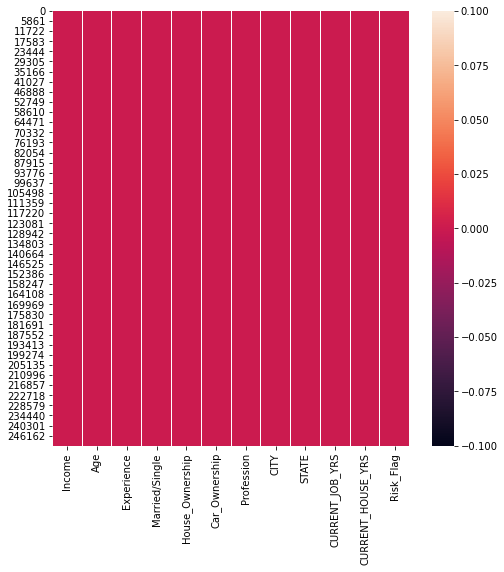

In [34]:
plt.figure(figsize=(8,8))
sns.heatmap(df.isnull())
plt.show()

There are no missing values in the given dataset

## 2.2 Outlier Analysis

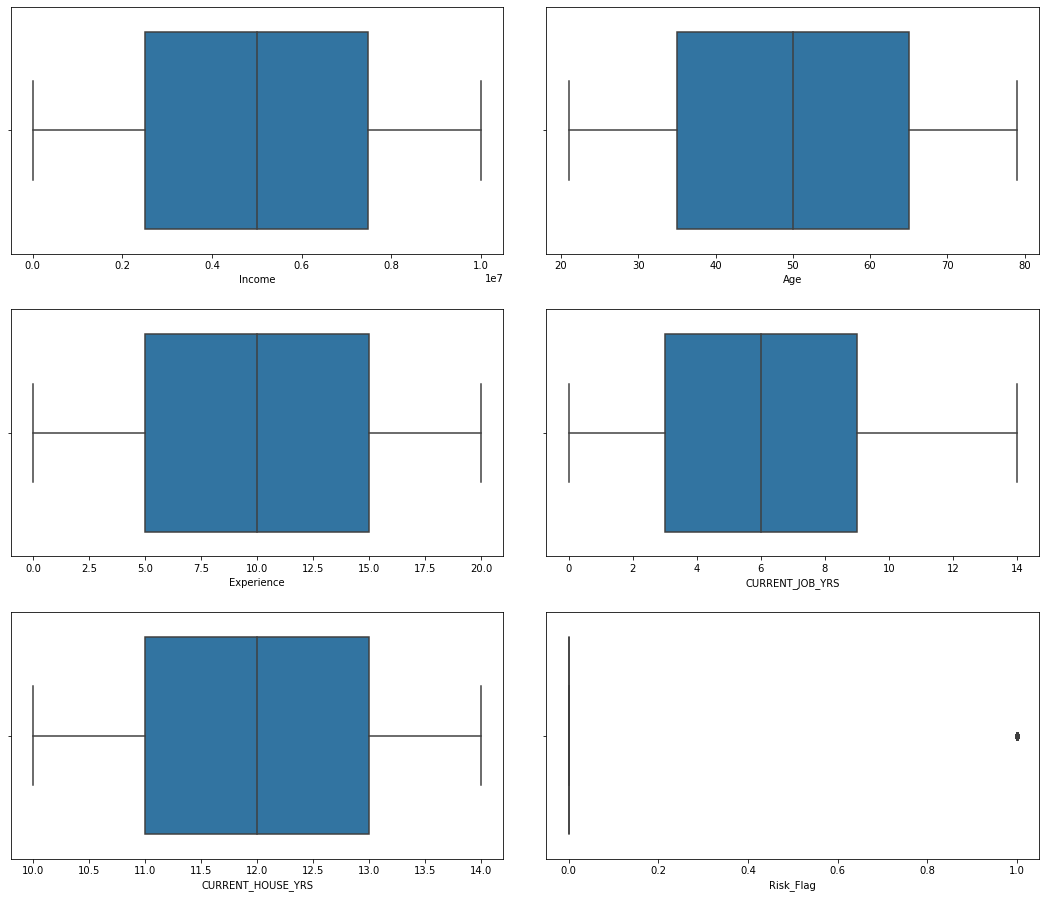

In [101]:
plt.figure(figsize=(15,25))
for index,i in enumerate(df.select_dtypes(include=np.number).columns):
    plt.subplot(6,2,index+1)
    plt.tight_layout(pad=2,h_pad=2)
    sns.boxplot(df[i])

It can be observed that there are no outliers present in the dataset

## 2.4 Creating New Columns for EDA

In [89]:
labels=[ 'Low_Income', 'Mid_Income', 'High_Income']
df['Income_Class']=pd.cut(df['Income'],3, labels=labels)

In [90]:
age_labels=[ '21 to 40', '41 to 60', '61 to 79']
df['Age_Group']=pd.cut(df['Age'],bins=[20,40,60,80], labels=age_labels)

In [95]:
exp_labels=[ '0-10 years','11-20 years']
df['Exp_level']=pd.cut(df['Experience'],bins=[0,10,20], labels=exp_labels)

In [156]:
North_Zone=['Himachal_Pradesh', 'Punjab','Chandigarh', 'Uttarakhand','Delhi' , 'Uttar_Pradesh' ,'Haryana','Jammu_and_Kashmir' ,'Uttar_Pradesh']
East_Zone=['Bihar', 'Odisha', 'Jharkhand', 'West_Bengal']
West_Zone=[ 'Rajasthan' , 'Gujarat', 'Goa' , 'Maharashtra']
South_Zone=['Andhra_Pradesh', 'Karnataka', 'Kerala' , 'Tamil_Nadu','Telangana','Puducherry']
Central_Zone=['Madhya_Pradesh' , 'Chhattisgarh']
Northeast_Zone=['Assam', 'Sikkim', 'Nagaland', 'Meghalaya', 'Manipur', 'Mizoram', 'Tripura' , 'Arunachal_Pradesh']


In [157]:
df['Zone']=df['STATE']
df['Zone']=df['Zone'].replace(North_Zone,'North')
df['Zone']=df['Zone'].replace(East_Zone,'East')
df['Zone']=df['Zone'].replace(West_Zone,'West')
df['Zone']=df['Zone'].replace(South_Zone,'South')
df['Zone']=df['Zone'].replace(Central_Zone,'Central')
df['Zone']=df['Zone'].replace(Northeast_Zone,'Northeast')

In [96]:
df.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,Income_Class,Age_Group,Exp_level,Zone
0,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,Low_Income,21 to 40,0-10 years,Central
1,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,High_Income,21 to 40,0-10 years,West
2,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,Mid_Income,61 to 79,0-10 years,South
3,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,Mid_Income,41 to 60,0-10 years,East
4,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,Mid_Income,41 to 60,11-20 years,South


# 3. Exploratory Data Analysis

## 3.1. Univariate Analysis

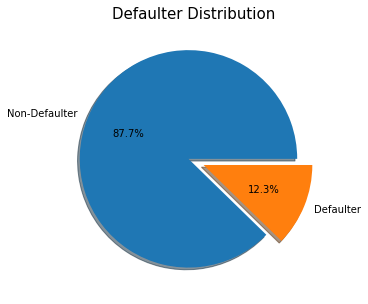

In [123]:
r = df.groupby('Risk_Flag')['Risk_Flag'].count()
plt.figure(figsize=(5,5))
plt.title('Defaulter Distribution',size=15)
plt.pie(r, explode=[0.05, 0.1], labels=['Non-Defaulter', 'Defaulter'], autopct='%1.1f%%',  shadow=True)
plt.show()

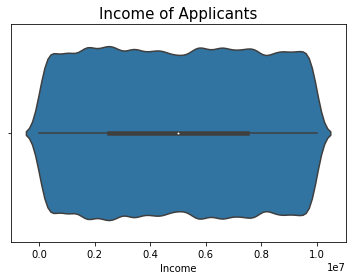

In [122]:
sns.violinplot(df['Income'])
plt.title('Income of Applicants',size=15)
plt.show()

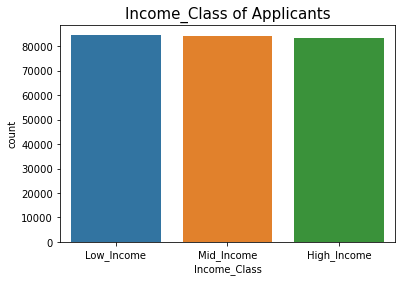

In [121]:
sns.countplot(df['Income_Class'])
plt.title('Income_Class of Applicants',size=15)
plt.show()

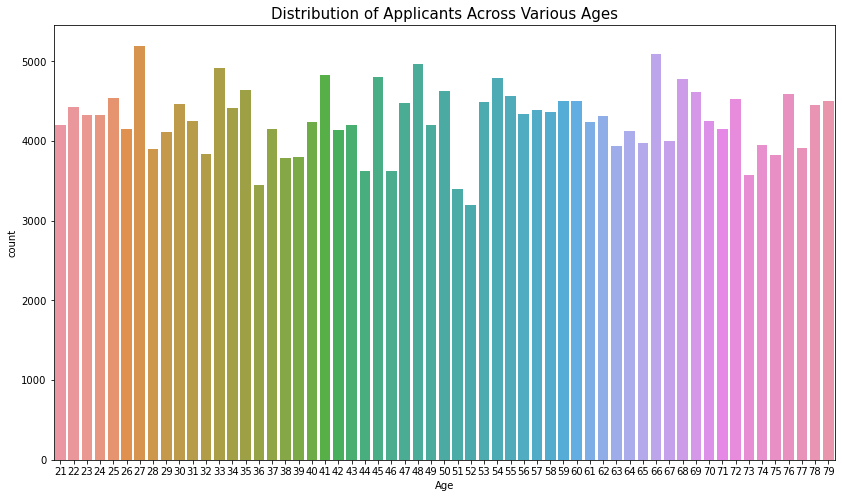

In [120]:
plt.figure(figsize=(14,8))
sns.countplot(df['Age'])
plt.title('Distribution of Applicants Across Various Ages',size=15)
plt.show()

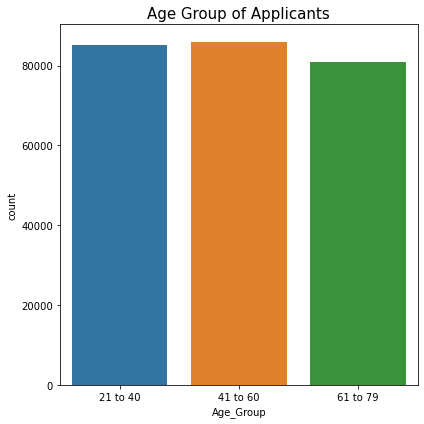

In [119]:
plt.figure(figsize=(6,6))
ax=sns.countplot(df['Age_Group'])
plt.title('Age Group of Applicants',size=15)
plt.tight_layout()
plt.show()

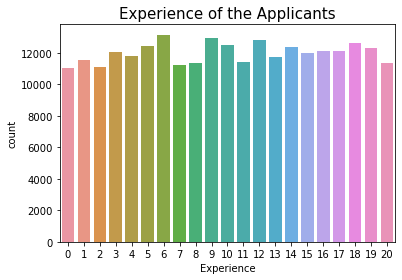

In [118]:
sns.countplot(df['Experience'])
plt.title('Experience of the Applicants',size=15)
plt.show()

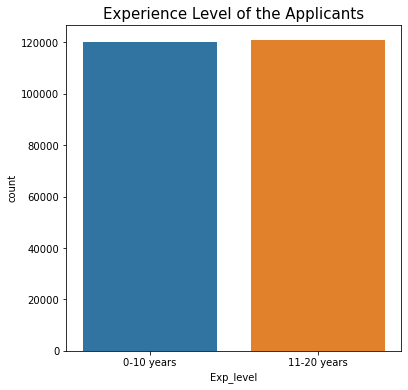

In [117]:
plt.figure(figsize=(6,6))
ax=sns.countplot(df['Exp_level'])
plt.title('Experience Level of the Applicants',size=15)
plt.show()

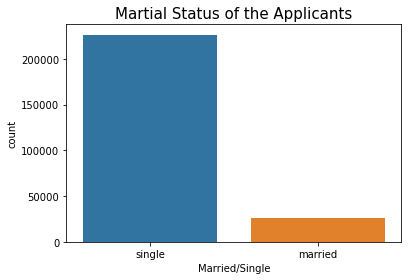

In [126]:
sns.countplot(df['Married/Single'])
plt.title('Martial Status of the Applicants',size=15)
plt.show()

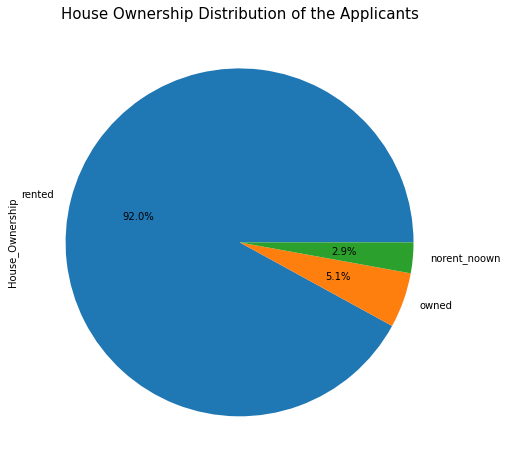

In [127]:
plt.figure(figsize=(14,8))
df['House_Ownership'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.title('House Ownership Distribution of the Applicants',size=15)
plt.show()

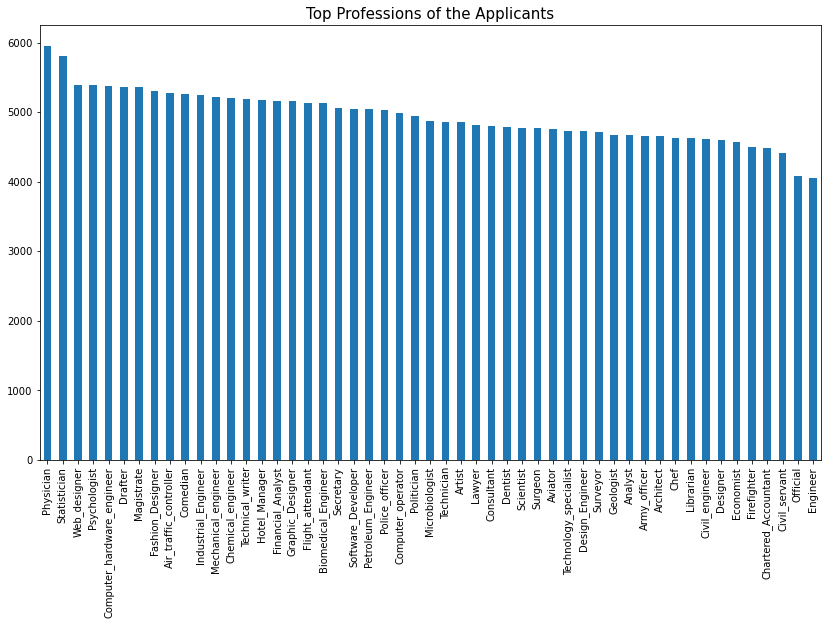

In [141]:
plt.figure(figsize=(14,8))
df['Profession'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Top Professions of the Applicants',size=15)
plt.show()

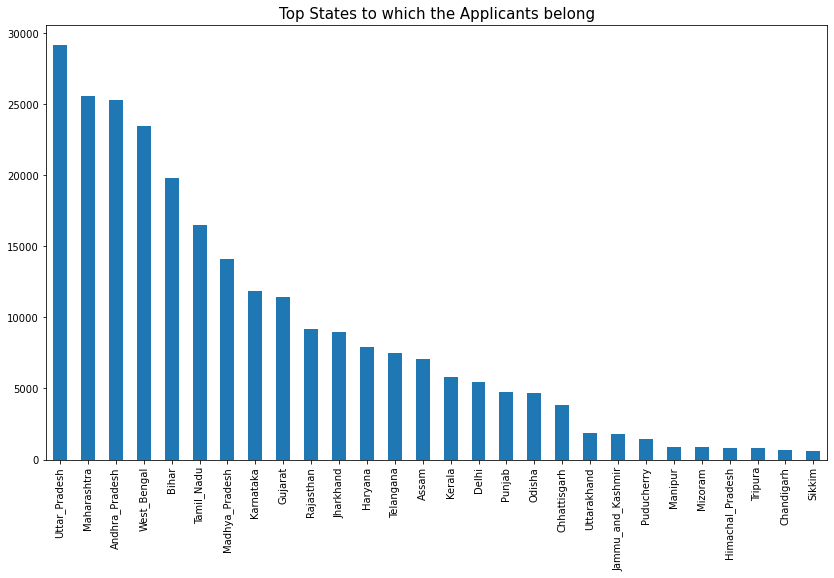

In [158]:
plt.figure(figsize=(14,8))
df['STATE'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Top States to which the Applicants belong',size=15)
plt.show()

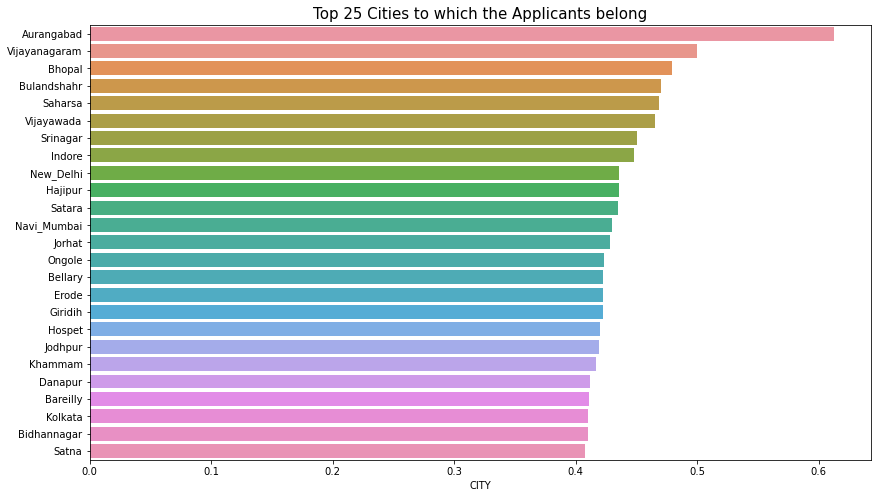

In [159]:
plt.figure(figsize=(14,8))
x = df.CITY.value_counts(1).sort_values(ascending=False)[:25] * 100
y = df.CITY.value_counts(1).sort_values(ascending=False)[:25].index
plt.title('Top 25 Cities to which the Applicants belong',size=15)

ax1 = sns.barplot(orient="h",x=x,y=y)

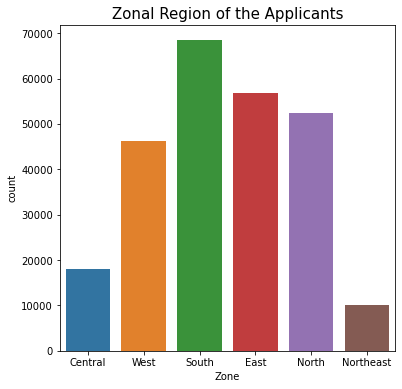

In [160]:
plt.figure(figsize=(6,6))
ax=sns.countplot(df['Zone'])
plt.title('Zonal Region of the Applicants',size=15)
plt.show()

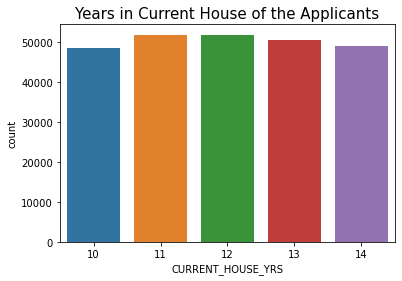

In [162]:
sns.countplot(df['CURRENT_HOUSE_YRS'])
plt.title('Years in Current House of the Applicants',size=15)
plt.show()

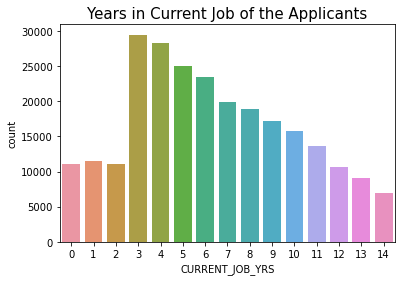

In [163]:
sns.countplot(df['CURRENT_JOB_YRS'])
plt.title('Years in Current Job of the Applicants',size=15)
plt.show()

## 3.2 Independent variables plotted against the Target Variable(Risk_Flag)

### 3.2.1 Numerical Variables Plotted against Risk_Flag

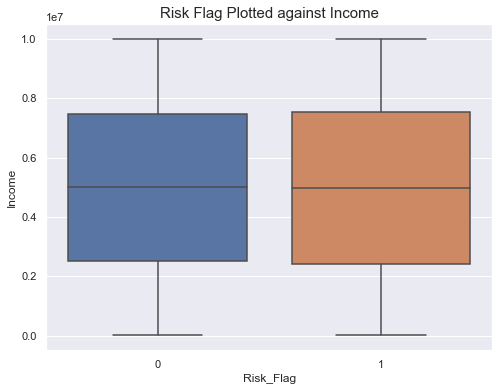

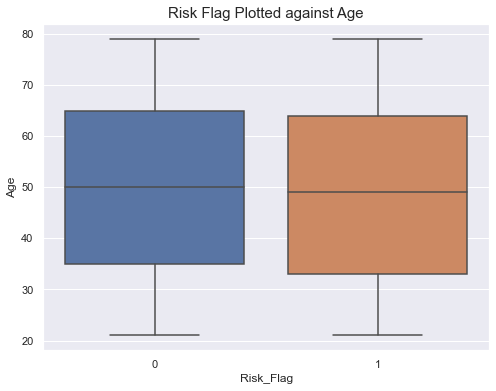

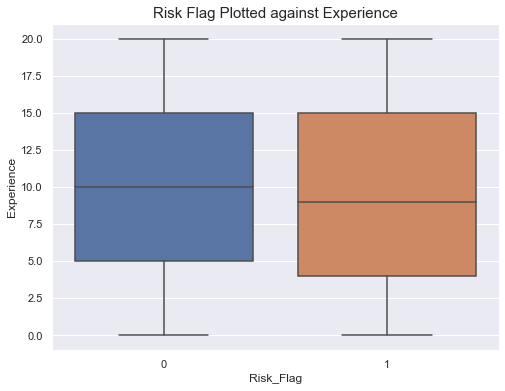

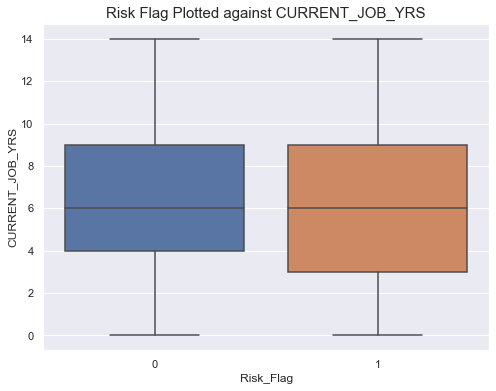

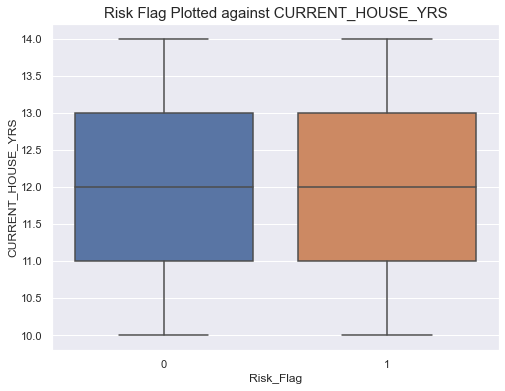

In [203]:
for col in ['Income', 'Age', 'Experience','CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS']:
    fig, ax = plt.subplots( figsize = (8,6) )
    plt.title(f'Risk Flag Plotted against {col}',size=15)
    sns.boxplot(x = "Risk_Flag", y = col, data = df)
    plt.show()

### 3.2.2 Categorical Variables Plotted against Risk_Flag

In [200]:
def plot_cat_features(feature_name, limit=10, ascending=False):

    # creates a df of categorical as index and risk_flag as columns, the values are the total counts.
    group_risk = df.groupby([feature_name,"Risk_Flag"])[feature_name].count().unstack()
    
    # loops through each row and updates the values as a percentage
    for row in group_risk.index:
        group_risk.loc[row] = group_risk.loc[row]/group_risk.loc[row].sum()
    
    # orders the values by highest percentage loan defaults first
    group_risk = group_risk.sort_values(by=1, ascending=ascending)[:limit]
    
    # plots the data as a bar plot
    group_risk.plot(kind="bar", figsize=(2*len(group_risk.index), 6))
    plt.title(f"{feature_name} vs Risk_Flag Count",size=15)
    plt.ylabel("Percentage");

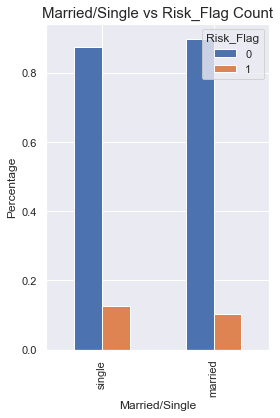

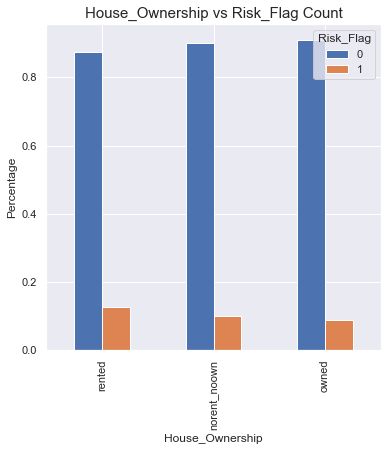

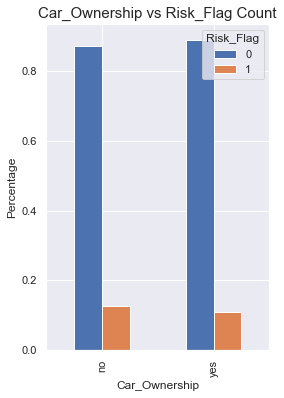

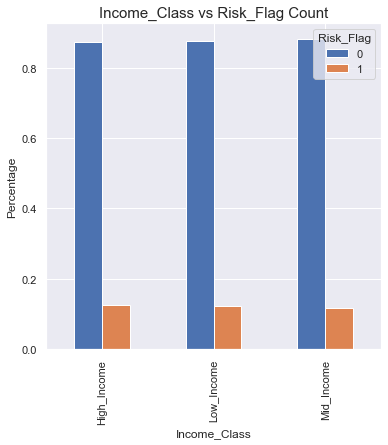

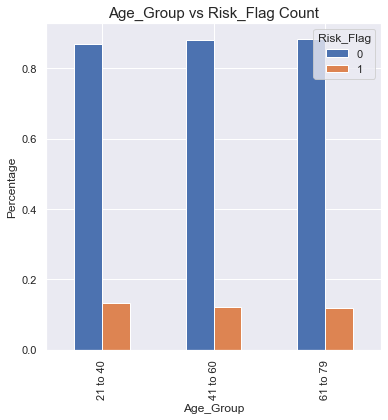

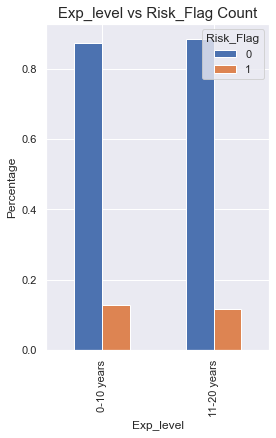

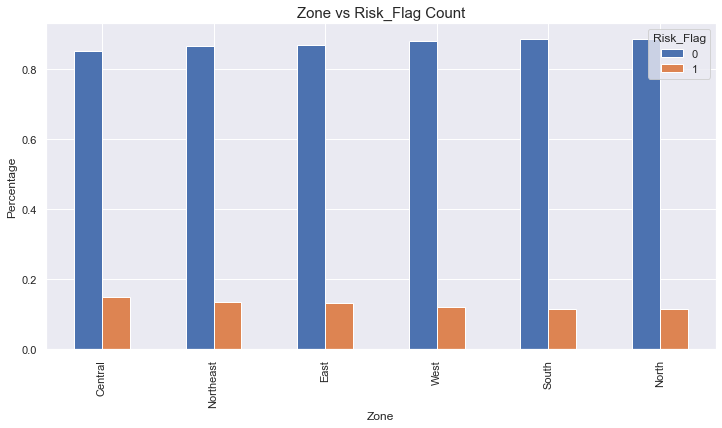

In [202]:
cat_col=['Married/Single', 'House_Ownership','Car_Ownership','Income_Class', 'Age_Group',
       'Exp_level', 'Zone']
for col in cat_col:
    plot_cat_features(col)

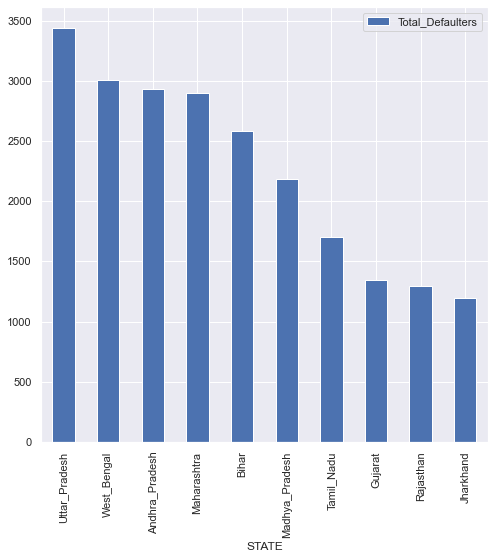

In [222]:
df_state = df.loc[df['Risk_Flag'] == 1].groupby(['STATE','Risk_Flag']).count()
df_state.rename(columns={'CITY':'Total_Defaulters'},inplace=True)
df_state.reset_index(inplace=True)
df_state[['STATE','Total_Defaulters']].sort_values(by='Total_Defaulters',ascending=False)[:10].plot(kind='bar',x='STATE',
                                                                                                    figsize=(8,8))
plt.show()

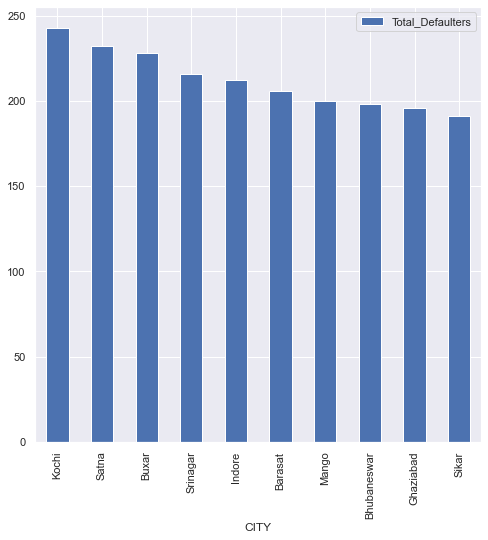

In [223]:
df_city = df.loc[df['Risk_Flag'] == 1].groupby(['CITY','Risk_Flag']).count()
df_city.rename(columns={'STATE':'Total_Defaulters'},inplace=True)
df_city.reset_index(inplace=True)
df_city[['CITY','Total_Defaulters']].sort_values(by='Total_Defaulters',ascending=False)[:10].plot(kind='bar',x='CITY',
                                                                                                    figsize=(8,8))
plt.show()

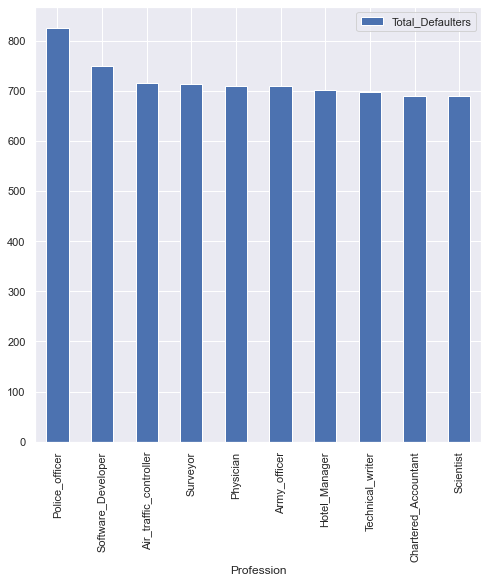

In [224]:
df_profession = df.loc[df['Risk_Flag'] == 1].groupby(['Profession','Risk_Flag']).count()
df_profession.rename(columns={'STATE':'Total_Defaulters'},inplace=True)
df_profession.reset_index(inplace=True)
df_profession[['Profession','Total_Defaulters']].sort_values(by='Total_Defaulters',ascending=False)[:10].plot(kind='bar',x='Profession',
                                                                                                    figsize=(8,8))
plt.show()